Epoch [1/5], Loss: 1.8938
Epoch [2/5], Loss: 1.4671
Epoch [3/5], Loss: 1.3682
Epoch [4/5], Loss: 1.3136
Epoch [5/5], Loss: 1.2724
Epoch [1/5], Loss: 1.7688
Epoch [2/5], Loss: 1.4594
Epoch [3/5], Loss: 1.3893
Epoch [4/5], Loss: 1.3509
Epoch [5/5], Loss: 1.3242


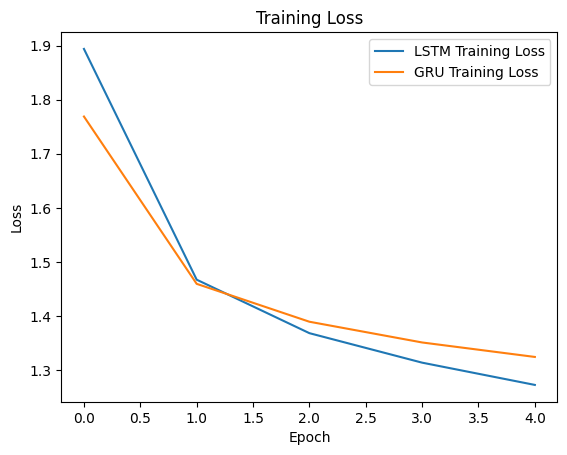

LSTM Loss: 1.272433448815852, LSTM Accuracy: 58.70626470917853%, LSTM Training Time: 309.19427609443665s
GRU Loss: 1.3241765926657774, GRU Accuracy: 57.559116888938696%, GRU Training Time: 287.98408603668213s


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import requests
import time
from torch.utils.data import Dataset, DataLoader

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 20  # Change to 30 for the second run
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]
# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)
# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

class CharDataset(Dataset):
    def __init__(self, sequences, targets, vocab_size):
        self.sequences = sequences
        self.targets = targets
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = self.sequences[index]
        target = self.targets[index]
        # One-hot encode the sequence
        sequence_one_hot = torch.zeros(sequence_length, self.vocab_size)
        sequence_one_hot[range(sequence_length), sequence] = 1
        return sequence_one_hot, target

# Instantiate the dataset
dataset = CharDataset(sequences, targets, len(chars))

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Batch size is the first dimension of input
        batch_size = x.size(0)
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])  # Decode the hidden state of the last time step
        return out

# Training function
def train_model(model, train_loader, test_loader, sequence_length, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    model.train()
    start_time = time.time()
    epoch_losses = []  # List to store loss values
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, (seq, target) in enumerate(train_loader):
            seq = seq.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Calculate average loss for the epoch
        epoch_loss /= len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    training_time = time.time() - start_time

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for seq, target in test_loader:
            seq = seq.to(device)
            target = target.to(device)
            outputs = model(seq)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return epoch_losses, accuracy, training_time


import matplotlib.pyplot as plt

# Hyperparameters
input_size = len(char_to_int)  # Size of the one-hot-encoded characters
hidden_size = 256  # Can be varied
output_size = input_size  # The output is a one-hot-encoded character
num_layers = 2  # Can be varied
num_epochs = 5  # Can be varied

# Instantiate the models
lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers)
gru_model = GRUModel(input_size, hidden_size, output_size, num_layers)

# Train the models and get the loss history
lstm_loss_history, lstm_accuracy, lstm_training_time = train_model(lstm_model, train_loader, test_loader, sequence_length, num_epochs)
gru_loss_history, gru_accuracy, gru_training_time = train_model(gru_model, train_loader, test_loader, sequence_length, num_epochs)

# Plot the training loss
plt.plot(lstm_loss_history, label='LSTM Training Loss')
plt.plot(gru_loss_history, label='GRU Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Report the metrics after training and plotting
print(f'LSTM Loss: {lstm_loss_history[-1]}, LSTM Accuracy: {lstm_accuracy}%, LSTM Training Time: {lstm_training_time}s')
print(f'GRU Loss: {gru_loss_history[-1]}, GRU Accuracy: {gru_accuracy}%, GRU Training Time: {gru_training_time}s')

Epoch [1/5], Loss: 1.8581
Epoch [2/5], Loss: 1.4533
Epoch [3/5], Loss: 1.3562
Epoch [4/5], Loss: 1.2994
Epoch [5/5], Loss: 1.2589
Epoch [1/5], Loss: 1.7624
Epoch [2/5], Loss: 1.4538
Epoch [3/5], Loss: 1.3834
Epoch [4/5], Loss: 1.3444
Epoch [5/5], Loss: 1.3175


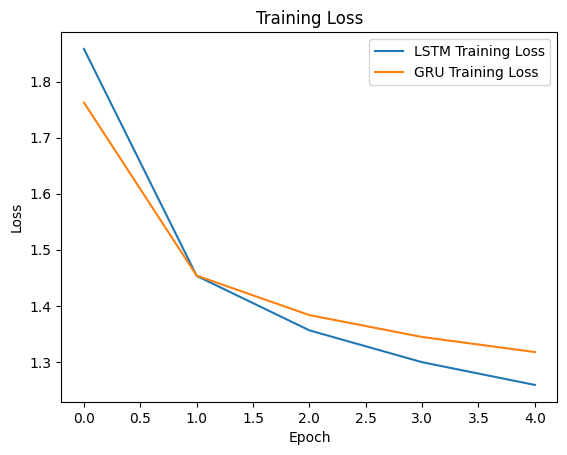

LSTM Loss: 1.258868815190342, LSTM Accuracy: 59.03493475230081%, LSTM Training Time: 374.4453339576721s
GRU Loss: 1.3174526941969487, GRU Accuracy: 58.23564483375397%, GRU Training Time: 348.82668232917786s


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import requests
import time
from torch.utils.data import Dataset, DataLoader

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 30  # Change to 30 for the second run
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]
# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)
# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

class CharDataset(Dataset):
    def __init__(self, sequences, targets, vocab_size):
        self.sequences = sequences
        self.targets = targets
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = self.sequences[index]
        target = self.targets[index]
        # One-hot encode the sequence
        sequence_one_hot = torch.zeros(sequence_length, self.vocab_size)
        sequence_one_hot[range(sequence_length), sequence] = 1
        return sequence_one_hot, target

# Instantiate the dataset
dataset = CharDataset(sequences, targets, len(chars))

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Batch size is the first dimension of input
        batch_size = x.size(0)
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])  # Decode the hidden state of the last time step
        return out

# Training function
def train_model(model, train_loader, test_loader, sequence_length, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    model.train()
    start_time = time.time()
    epoch_losses = []  # List to store loss values
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, (seq, target) in enumerate(train_loader):
            seq = seq.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Calculate average loss for the epoch
        epoch_loss /= len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    training_time = time.time() - start_time

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for seq, target in test_loader:
            seq = seq.to(device)
            target = target.to(device)
            outputs = model(seq)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return epoch_losses, accuracy, training_time


import matplotlib.pyplot as plt

# Hyperparameters
input_size = len(char_to_int)  # Size of the one-hot-encoded characters
hidden_size = 256  # Can be varied
output_size = input_size  # The output is a one-hot-encoded character
num_layers = 2  # Can be varied
num_epochs = 5  # Can be varied

# Instantiate the models
lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers)
gru_model = GRUModel(input_size, hidden_size, output_size, num_layers)

# Train the models and get the loss history
lstm_loss_history, lstm_accuracy, lstm_training_time = train_model(lstm_model, train_loader, test_loader, sequence_length, num_epochs)
gru_loss_history, gru_accuracy, gru_training_time = train_model(gru_model, train_loader, test_loader, sequence_length, num_epochs)

# Plot the training loss
plt.plot(lstm_loss_history, label='LSTM Training Loss')
plt.plot(gru_loss_history, label='GRU Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Report the metrics after training and plotting
print(f'LSTM Loss: {lstm_loss_history[-1]}, LSTM Accuracy: {lstm_accuracy}%, LSTM Training Time: {lstm_training_time}s')
print(f'GRU Loss: {gru_loss_history[-1]}, GRU Accuracy: {gru_accuracy}%, GRU Training Time: {gru_training_time}s')

Epoch [1/5], Loss: 1.8484
Epoch [2/5], Loss: 1.4413
Epoch [3/5], Loss: 1.3429
Epoch [4/5], Loss: 1.2851
Epoch [5/5], Loss: 1.2432
Epoch [1/5], Loss: 1.7587
Epoch [2/5], Loss: 1.4478
Epoch [3/5], Loss: 1.3748
Epoch [4/5], Loss: 1.3332
Epoch [5/5], Loss: 1.3056


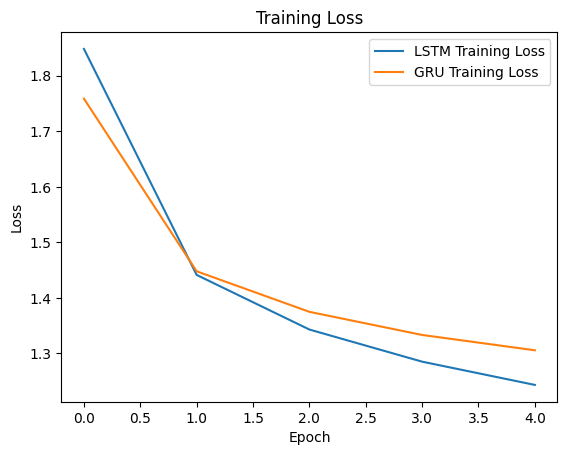

LSTM Loss: 1.243177270909803, LSTM Accuracy: 59.640738964177004%, LSTM Training Time: 551.5164937973022s
GRU Loss: 1.3055628704436453, GRU Accuracy: 58.4594901129247%, GRU Training Time: 474.5350558757782s


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import requests
import time
from torch.utils.data import Dataset, DataLoader

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 50  # Change to 30 for the second run
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]
# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)
# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

class CharDataset(Dataset):
    def __init__(self, sequences, targets, vocab_size):
        self.sequences = sequences
        self.targets = targets
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = self.sequences[index]
        target = self.targets[index]
        # One-hot encode the sequence
        sequence_one_hot = torch.zeros(sequence_length, self.vocab_size)
        sequence_one_hot[range(sequence_length), sequence] = 1
        return sequence_one_hot, target

# Instantiate the dataset
dataset = CharDataset(sequences, targets, len(chars))

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Batch size is the first dimension of input
        batch_size = x.size(0)
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])  # Decode the hidden state of the last time step
        return out

# Training function
def train_model(model, train_loader, test_loader, sequence_length, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    model.train()
    start_time = time.time()
    epoch_losses = []  # List to store loss values
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, (seq, target) in enumerate(train_loader):
            seq = seq.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Calculate average loss for the epoch
        epoch_loss /= len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    training_time = time.time() - start_time

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for seq, target in test_loader:
            seq = seq.to(device)
            target = target.to(device)
            outputs = model(seq)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return epoch_losses, accuracy, training_time


import matplotlib.pyplot as plt

# Hyperparameters
input_size = len(char_to_int)  # Size of the one-hot-encoded characters
hidden_size = 256  # Can be varied
output_size = input_size  # The output is a one-hot-encoded character
num_layers = 2  # Can be varied
num_epochs = 5  # Can be varied

# Instantiate the models
lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers)
gru_model = GRUModel(input_size, hidden_size, output_size, num_layers)

# Train the models and get the loss history
lstm_loss_history, lstm_accuracy, lstm_training_time = train_model(lstm_model, train_loader, test_loader, sequence_length, num_epochs)
gru_loss_history, gru_accuracy, gru_training_time = train_model(gru_model, train_loader, test_loader, sequence_length, num_epochs)

# Plot the training loss
plt.plot(lstm_loss_history, label='LSTM Training Loss')
plt.plot(gru_loss_history, label='GRU Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Report the metrics after training and plotting
print(f'LSTM Loss: {lstm_loss_history[-1]}, LSTM Accuracy: {lstm_accuracy}%, LSTM Training Time: {lstm_training_time}s')
print(f'GRU Loss: {gru_loss_history[-1]}, GRU Accuracy: {gru_accuracy}%, GRU Training Time: {gru_training_time}s')